In [1]:
%matplotlib inline

In [2]:
import torch
import os

import pandas as pd
import numpy as np

from matplotlib import pyplot as plt

from torchcast.state_space import Predictions
from torchcast.utils.datasets import load_air_quality_data
from torchcast.kalman_filter import KalmanFilter
from torchcast.utils.data import TimeSeriesDataset

from plotnine import facet_wrap

np.random.seed(2025-3-12)
torch.manual_seed(2025-3-12)

# Multivariate Forecasts: Beijing Multi-Site Air-Quality Data

We'll demonstrate several features of `torchcast` using a dataset from the [UCI Machine Learning Data Repository](https://archive.ics.uci.edu/dataset/501/beijing+multi+site+air+quality+data). It includes data on air pollutants and weather from 12 sites.

In [3]:
df_aq = load_air_quality_data('daily')

SPLIT_DT = np.datetime64('2016-02-22')
df_aq['dataset'] = np.where(df_aq['date'] > SPLIT_DT, 'val', 'train')
df_aq

,date,station,PM2p5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,WSPM,dataset
0,2013-03-01,Aotizhongxin,7.125000,10.750000,11.708333,22.583333,429.166667,63.875000,1.391667,1026.875000,-18.745833,0.0,3.254167,train
1,2013-03-01,Changping,5.083333,18.958333,16.041667,15.333333,387.500000,77.791667,0.812500,1023.858333,-19.583333,0.0,2.133333,train
2,2013-03-01,Dingling,6.375000,6.409091,3.000000,2.625000,204.166667,81.958333,0.812500,1023.858333,-19.583333,0.0,2.133333,train
3,2013-03-01,Dongsi,6.416667,9.875000,8.478261,28.521739,395.652174,72.782609,1.325000,1028.783333,-21.466667,0.0,3.308333,train
4,2013-03-01,Guanyuan,7.541667,11.666667,8.500000,28.500000,400.000000,63.166667,1.391667,1026.875000,-18.745833,0.0,3.254167,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17527,2017-02-28,Nongzhanguan,17.523810,24.739130,7.347826,35.652174,526.086957,56.086957,10.958333,1014.887500,-12.783333,0.0,2.058333,val
17528,2017-02-28,Shunyi,20.708333,28.500000,7.125000,39.666667,579.166667,57.291667,9.250000,1015.550000,-10.429167,0.0,2.025000,val
17529,2017-02-28,Tiantan,14.875000,32.708333,6.454545,42.904762,540.909091,57.600000,10.958333,1014.887500,-12.783333,0.0,2.058333,val
17530,2017-02-28,Wanliu,9.958333,25.583333,7.458333,40.916667,479.166667,54.791667,10.516667,1013.345833,-12.266667,0.0,1.800000,val


### Univariate Forecasts

Let's try to build a model to predict total particulate-matter (PM2.5 and PM10). 

First, we'll make our target the sum of these two types. We'll log-transform since this is strictly positive.

In [4]:
from torchcast.process import LocalTrend, Season

# dataset:
df_aq['PM'] = df_aq['PM10'] + df_aq['PM2p5'] 
df_aq['PM_log10'] = np.log10(df_aq['PM']) 
dataset_pm = TimeSeriesDataset.from_dataframe(
    dataframe=df_aq,
    dt_unit='D',
    measure_colnames=['PM_log10'],
    group_colname='station', 
    time_colname='date'
)
dataset_pm_train, _ = dataset_pm.train_val_split(dt=SPLIT_DT)

# model:
kf_pm = KalmanFilter(
    measures=['PM_log10'], 
    processes=[
        LocalTrend(id='trend'),
        Season(
            id='day_in_year', 
            period=365.25, 
            dt_unit='D', 
            K=5,
            fixed=True
        ),
        Season(
            id='day_in_week', 
            period=7, 
            dt_unit='D', 
            K=2,
            fixed=True
        )
    ]
)

# fit:
kf_pm.fit(
    dataset_pm_train.tensors[0],
    start_offsets=dataset_pm_train.start_datetimes,
    n_step=5, every_step=False
)

Initializing trend.position to 2.152986526489258


  0%|          | 0/8 [00:00<?, ?it/s]

KalmanFilter(processes=[LocalTrend(id='trend'), Season(id='day_in_year'), Season(id='day_in_week')], measures=['PM_log10'])

Let's see how our forecasts look:

In [5]:
!say done

Subsetting to groups: ['Aotizhongxin', 'Dingling']


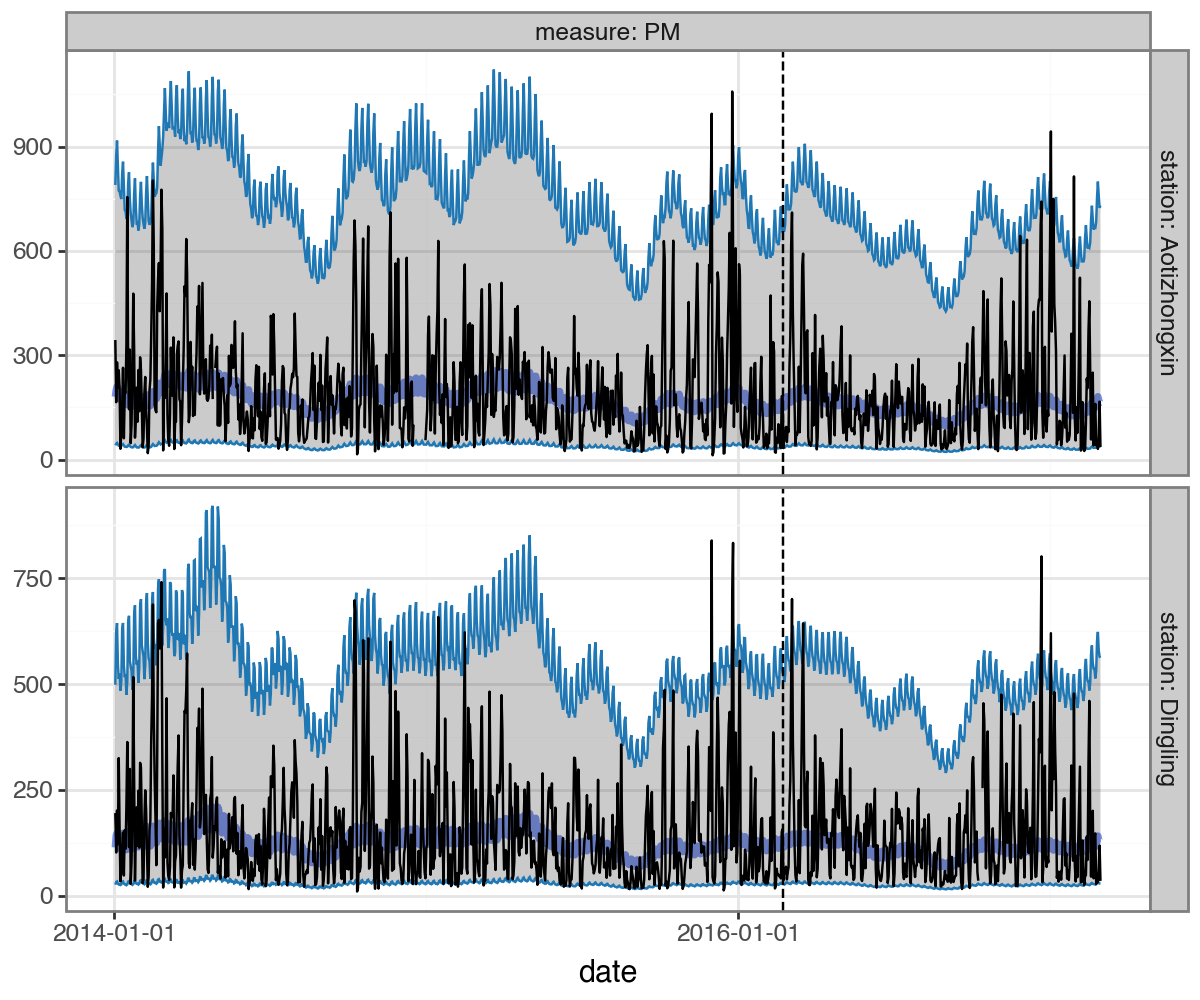

In [34]:
# helper for transforming log back to original:
def inverse_transform(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    # bias-correction for log-transform (see https://otexts.com/fpp2/transformations.html#bias-adjustments)
    df['mean'] = df['mean'] + .5 * df['std'] ** 2
    df['lower'] = df['mean'] - 1.96 * df['std']
    df['upper'] = df['mean'] + 1.96 * df['std']
    # inverse the log10:
    df[['actual', 'mean', 'upper', 'lower']] = 10 ** df[['actual', 'mean', 'upper', 'lower']]
    df['measure'] = df['measure'].str.replace('_log10', '')
    return df

# generate forecasts:
forecast = kf_pm(
        dataset_pm_train.tensors[0],
        start_offsets=dataset_pm_train.start_datetimes,
        out_timesteps=dataset_pm.tensors[0].shape[1]
)

df_uv_pred = (forecast
             .set_metadata(group_colname='station', time_colname='date')
             .to_dataframe(dataset_pm, conf=None)
             .pipe(inverse_transform))
forecast.plot(
    df_uv_pred.query("date>'2014-01-01'"), 
    max_num_groups=2, 
    split_dt=SPLIT_DT, 
    figure_size=(6,5)
)

### Multivariate Forecasts

Can we improve our model by splitting the pollutant we are forecasting into its two types (2.5 and 10), and modeling them in a multivariate manner?

## Comparison

### Statsmodels

In [7]:
# from statsmodels.tsa.arima.model import ARIMA

# # fit:
# arima_models_by_station = {}
# for s, df in df_aq.query("week <= @SPLIT_DT").groupby('station'):
#     arima_models_by_station[s] = ARIMA(
#         order=(0, 0, 1), 
#         seasonal_order=(0, 0, 1, 52), 
#         endog=df[['week', 'PM_log10']].set_index('week'),
#         freq='W-MON'
#     ).fit()

# # forecast:
# df_arima = pd.concat([
    
#     arima
#     .get_prediction(end=df_aq['week'].max())
#     .summary_frame()
#     .reset_index()
#     .rename(columns={'index' : 'week'})
#     .assign(station=station)
    
#     for station, arima in arima_models_by_station.items()
# ]).reset_index(drop=True)
# df_arima.columns.name = None
# df_arima

In [8]:
# (
#     ggplot(df_aq
#            .loc[:,['station', 'week', 'PM_log10']]
#            .merge(df_arima, how='left', on=['week', 'station'])
#            .assign(measure='PM')
#            .rename(columns={'mean_se' : 'std', 'PM_log10' : 'actual'})
#            .pipe(inverse_transform)
#            .query("station.isin(['Gucheng', 'Huairou', 'Shunyi'])")
#            ,
#         aes(x='week', y='actual')) 
    
#     + geom_line() 
#     + facet_wrap('station', ncol=1)
#     + geom_line(aes(y='mean'), color='blue')
#     + geom_ribbon(aes(ymin='lower', ymax='upper'), fill='blue', alpha=.2)
#     + geom_hline(yintercept=0)
#     + geom_vline(xintercept=SPLIT_DT, linetype='dashed') 
#     + ylab("")
# )

### Nixtla

In [9]:
# from statsforecast.models import AutoARIMA
# from statsforecast import StatsForecast

# sf = StatsForecast(
#     models=[AutoARIMA(season_length=52)],
#     freq='W-MON',
# )
# sf.fit(
#     df_aq.loc[df_aq['week'] <= SPLIT_DT, ['week', 'station', 'PM_log10']],
#     id_col='station',
#     time_col='week',
#     target_col='PM_log10'
# )

# df_auto_arima_preds = sf.predict(h=52, level=[95])
# df_auto_arima_preds

In [10]:
# foo = (df_aq
#        .loc[:,['station', 'week', 'PM_log10']]
#        .merge(df_auto_arima_preds, how='left')
#        .assign(std = lambda df: (df.pop('AutoARIMA-hi-95') - df.pop('AutoARIMA-lo-95')) / (1.96 * 2),
#                measure='PM')
#        .rename(columns={'AutoARIMA' : 'mean', 'PM_log10' : 'actual'})
#        .pipe(inverse_transform))
# foo
# (
#     ggplot(foo.query("station.isin(['Gucheng', 'Huairou', 'Shunyi'])"), 
#                      aes(x='week', y='actual')) 
#     + geom_line() 
#     + facet_wrap('station', ncol=1)
#     + geom_line(aes(y='mean'), color='blue')
#     + geom_ribbon(aes(ymin='lower', ymax='upper'), fill='blue', alpha=.2)
#     + geom_hline(yintercept=0)
#     + geom_vline(xintercept=SPLIT_DT, linetype='dashed') 
#     + ylab("")
#     + theme(figure_size=(5,5))
# )

In [11]:
# create a dataset:
df_aq['PM10_log10'] = np.log10(df_aq['PM10'])
df_aq['PM2p5_log10'] = np.log10(df_aq['PM2p5'])
dataset_pm_multivariate = TimeSeriesDataset.from_dataframe(
    dataframe=df_aq,
    dt_unit='D',
    measure_colnames=['PM10_log10','PM2p5_log10'],
    group_colname='station', 
    time_colname='date'
)
dataset_pm_multivariate_train, _ = dataset_pm_multivariate.train_val_split(dt=SPLIT_DT)

# create a model:
_processes = []
for m in dataset_pm_multivariate.measures[0]:
    _processes.extend([
        LocalTrend(id=f'{m}_trend', measure=m),
        Season(
            id=f'{m}_day_in_year', 
            period=365.25, 
            dt_unit='D', 
            K=4, 
            measure=m, 
            fixed=True
        ),
        
        Season(
            id=f'{m}_day_in_week', 
            period=7, 
            dt_unit='D', 
            K=2,
            measure=m,
            fixed=True
        )
    ])
kf_pm_multivariate = KalmanFilter(measures=dataset_pm_multivariate.measures[0], processes=_processes)

# fit:
kf_pm_multivariate.fit(
    dataset_pm_multivariate_train.tensors[0],
    start_offsets=dataset_pm_multivariate_train.start_datetimes,
    n_step=5, every_step=False,
)

Initializing PM10_log10_trend.position to 1.9197293519973755
Initializing PM2p5_log10_trend.position to 1.7517921924591064


  0%|          | 0/8 [00:00<?, ?it/s]

KalmanFilter(processes=[LocalTrend(id='PM10_log10_trend'), Season(id='PM10_log10_day_in_year'), Season(id='PM10_log10_day_in_week'), LocalTrend(id='PM2p5_log10_trend'), Season(id='PM2p5_log10_day_in_year'), Season(id='PM2p5_log10_day_in_week')], measures=['PM10_log10', 'PM2p5_log10'])

In [12]:
!say done

We can generate our one-month-ahead predictions for validation as we did before:

In [13]:
with torch.no_grad():
    forecast_mv = kf_pm_multivariate(
        dataset_pm_multivariate_train.tensors[0],
        start_offsets=dataset_pm_multivariate_train.start_datetimes,
        out_timesteps=dataset_pm_multivariate.num_timesteps # <--- how we ask it to forecast past original times
    )
forecast_mv.means.shape

torch.Size([12, 1461, 2])

At this point, though, we run into a problem: we we have forecasts for both PM2.5 and PM10, but we ultimately want a forecast for their *sum*. With untransformed data, we could take advantage of the fact that [sum of correlated normals is still normal](https://en.wikipedia.org/wiki/Sum_of_normally_distributed_random_variables#Correlated_random_variables); but we have log-transformed our measures. This seems like it was the right choice (i.e. our residuals look reasonably normal and i.i.d):

Subsetting to groups: ['Wanshouxigong']


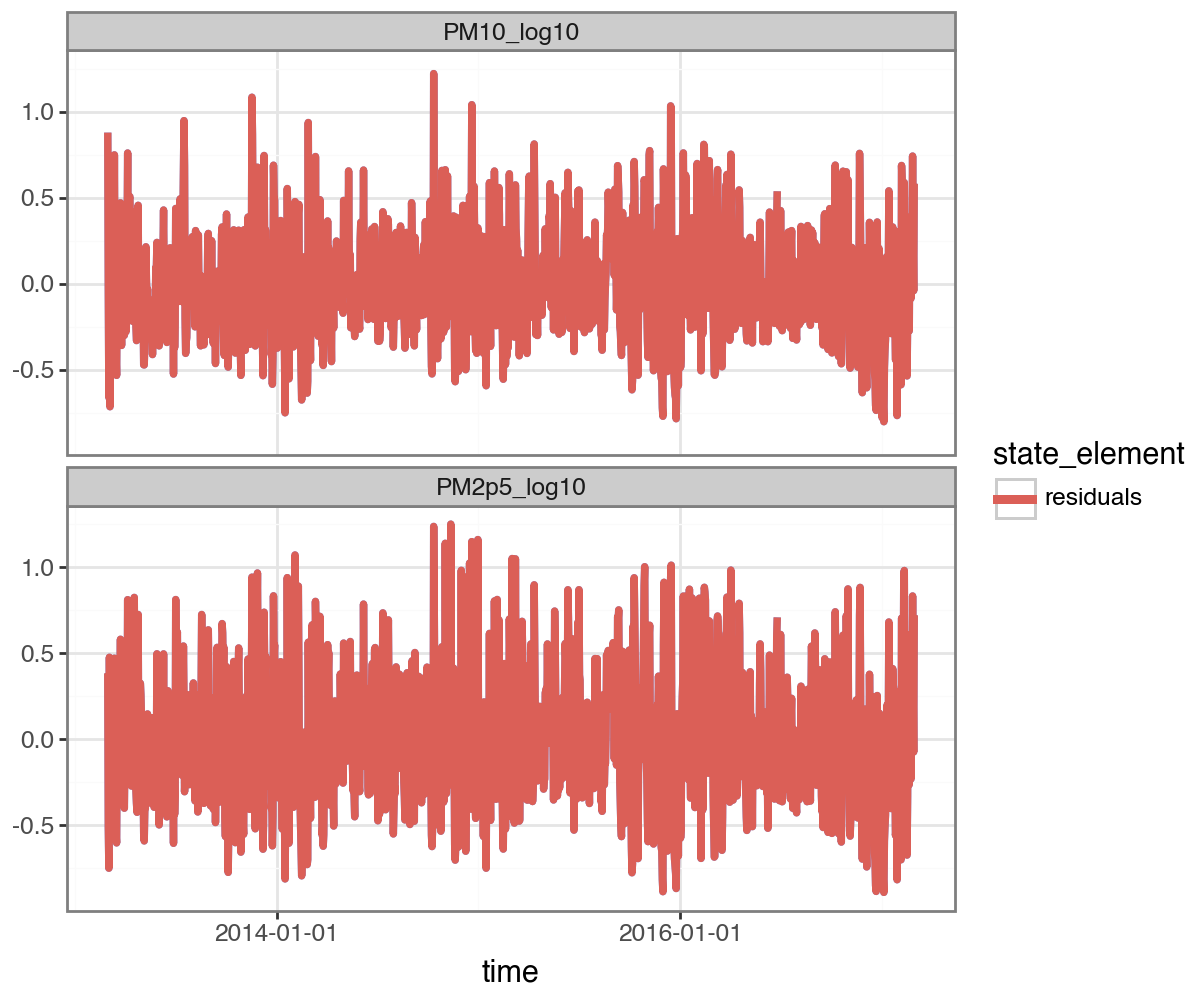

In [14]:
forecast_mv.plot(
    forecast_mv.to_dataframe(dataset_pm_multivariate, type='components').query("process=='residuals'"),
    time_colname='time', group_colname='group',
    figure_size=(6,5)
) + facet_wrap('measure', ncol=1)

In this case, we can't take the sum of our forecasts to get the forecast of the sum, and [there's no simple closed-form expression for the sum of lognormals](https://scholar.google.com/scholar?hl=en&as_sdt=0%2C14&q=SUMS+OF+LOGNORMALS&btnG=).

One option that is fairly easy in `torchcast` is to use a [Monte-Carlo](https://en.wikipedia.org/wiki/Monte_Carlo_method) approach: we'll just generate random-samples based on the means and covariances underlying our forecast. In that case, the sum of the PM2.5 + PM10 forecasted-samples *is* the forecasted PM sum we are looking for:

In [75]:
@torch.no_grad()
def mc_preds_to_dataframe(preds: Predictions,
                          dataset: TimeSeriesDataset,
                          inverse_transform_fun: callable,
                          num_draws: int = 1000,
                          **kwargs) -> pd.DataFrame:
    """
    Our predictions are on the transformed scale, and we'd like to sum across measures on the original scale;
    this function uses a monte-carlo approach to do this.
    """
    # generate draws from the forecast distribution, apply inverse-transform:
    mean, cov = preds
    eps = 1e-6 * torch.eye(cov.shape[-1]).unsqueeze(0).unsqueeze(0) # handle numerical instability
    mc_draws = torch.distributions.MultivariateNormal(mean, cov + eps, validate_args=False).rsample((num_draws,))
    # sum across measures (e.g. 2.5 and 10), then mean across draws:
    mc_predictions = inverse_transform_fun(mc_draws).sum(-1, keepdim=True).mean(0)
    # convert to a dataframe
    return TimeSeriesDataset.tensor_to_dataframe(
        mc_predictions,
        times=dataset.times(),
        group_names=dataset.group_names,
        measures=['predicted'],
        **kwargs
    )

In [76]:
df_mv_pred = mc_preds_to_dataframe(
    forecast_mv,
    dataset_pm_multivariate,
    inverse_transform_fun=lambda x: 10 ** x,
    group_colname='station',
    time_colname='date'
)
df_mv_pred

,predicted,station,date
0,3.564344e+06,Aotizhongxin,2013-03-01
1,9.577922e+01,Aotizhongxin,2013-03-02
2,8.318327e+01,Aotizhongxin,2013-03-03
3,1.390949e+02,Aotizhongxin,2013-03-04
4,2.355152e+02,Aotizhongxin,2013-03-05
...,...,...,...
1456,2.040827e+02,Wanshouxigong,2017-02-24
1457,2.083253e+02,Wanshouxigong,2017-02-25
1458,1.903995e+02,Wanshouxigong,2017-02-26
1459,1.939265e+02,Wanshouxigong,2017-02-27


### Evaluating Performance

In [77]:
def get_station_error(df: pd.DataFrame, pred_colname: str = 'mean', actual_colname: str = 'actual') -> pd.DataFrame:
    return (df
             .assign(sq_error=lambda df: (df[pred_colname] - df[actual_colname]) ** 2)
             .groupby(['station'])
             ['sq_error'].mean()
             .reset_index()
             .assign(rmse= lambda df: df['sq_error'] ** .5))

def agg_within_group_err(df: pd.DataFrame, error_col : str = 'rmse', group_col: str = 'station') -> pd.DataFrame:
    df = df.copy(deep=False)
    df['error_norm'] = df[error_col] - df.groupby(group_col)[error_col].transform('mean')
    return df.groupby('model').agg(**{error_col : (error_col, 'mean'), 'sem' : ('error_norm', 'sem')})

In [78]:
df_fct_err = pd.concat([
            df_uv_pred
             .loc[lambda df: df['date'] > SPLIT_DT,:]
             .pipe(get_station_error)
             .assign(model='univariate')
            ,
            df_mv_pred
             .loc[lambda df: df['date'] > SPLIT_DT,:]
             .merge(df_aq.loc[:, ['station', 'date', 'PM']])
             .pipe(get_station_error, pred_colname='predicted', actual_colname='PM')
             .assign(model='multivariate')
]).reset_index(drop=True)
df_fct_err.sort_values('station').tail(6)

,station,sq_error,rmse,model
21,Tiantan,22283.060613,149.275117,multivariate
9,Tiantan,23206.398438,152.336472,univariate
22,Wanliu,20288.673824,142.438316,multivariate
10,Wanliu,20764.509766,144.098953,univariate
11,Wanshouxigong,24770.328125,157.385925,univariate
23,Wanshouxigong,23728.140758,154.039413,multivariate


We see that this approach has reduced our error substantially in the validation period (though at the cost of slightly increasing it in the training period). We can look at the per-site differences to reduce noise:

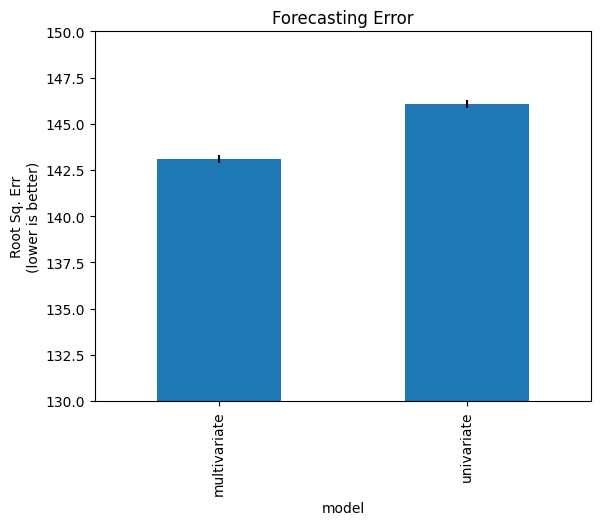

In [79]:
df_fct_err_agg = agg_within_group_err(df_fct_err)

# https://chris-said.io/2014/12/01/independent-t-tests-and-the-83-confidence-interval-a-useful-trick-for-eyeballing-your-data/
from scipy import stats
sem_multi = -stats.norm.ppf((1 - .83) / 2)

df_fct_err_agg['rmse'].plot(
    kind='bar', 
    yerr=df_fct_err_agg['sem'] * sem_multi, 
    ylabel="Root Sq. Err\n(lower is better)", 
    title="Forecasting Error",
    ylim=(130,150)
)
plt.show()

### Backtesting

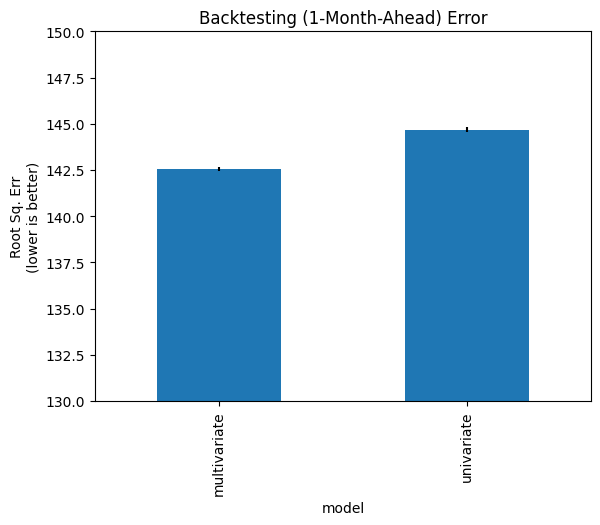

In [23]:
with torch.no_grad():
    one_mo_uv = kf_pm(
        dataset_pm.tensors[0],
        start_offsets=dataset_pm.start_datetimes,
        n_step=30
    )
    one_mo_mv = kf_pm_multivariate(
        dataset_pm_multivariate.tensors[0],
        start_offsets=dataset_pm_multivariate.start_datetimes,
        n_step=30
    )
    
df_backtest_err1mo = pd.concat([

    one_mo_uv
    .to_dataframe(dataset_pm, time_colname='date', group_colname='station', conf=None)
    .pipe(inverse_transform)
    .loc[lambda df: df['date'] > SPLIT_DT, :]
    .pipe(get_station_error)
    .assign(model='univariate')
    ,

    mc_preds_to_dataframe(one_mo_mv,
                          dataset_pm_multivariate,
                          inverse_transform_fun=lambda x: 10 ** x,
                          group_colname='station',
                          time_colname='date')
    .loc[lambda df: df['date'] > SPLIT_DT,:]
    .merge(df_aq[['station', 'date', 'PM']])
    .pipe(get_station_error, pred_colname='predicted', actual_colname='PM')
    .assign(model='multivariate')
])

df_backtest1mo_err_agg = agg_within_group_err(df_backtest_err1mo)

df_backtest1mo_err_agg['rmse'].plot(
    kind='bar', 
    yerr=df_backtest1mo_err_agg['sem'], 
    ylabel="Root Sq. Err\n(lower is better)", 
    title="Backtesting (1-Month-Ahead) Error",
    ylim=(130,150)
)
plt.show()

### Adding Predictors

In many settings we have external (a.k.a. _exogenous_) predictors we'd like to incorporate. Here we'll use four predictors corresponding to weather conditions. Of course, in a forecasting context, we run into the problem of needing to fill in values for these predictors for future dates. For an arbitrary forecast horizon this can be a complex issue; for simplicity here we'll focus on the 4-week-ahead predictions we used above, and simply lag our weather predictors by 4.

In [25]:
from torchcast.process import LinearModel

# prepare external predictors:
predictors_raw = ['TEMP', 'PRES', 'DEWP']
predictors = [p.lower() + '_lag30' for p in predictors_raw]
# standardize:
predictor_means = df_aq.query("dataset=='train'")[predictors_raw].mean()
predictor_stds = df_aq.query("dataset=='train'")[predictors_raw].std()
df_aq[predictors] = (df_aq[predictors_raw] - predictor_means) / predictor_stds
# lag:
df_aq[predictors] = df_aq.groupby('station')[predictors].shift(30, fill_value=0)

# create dataset:
dataset_pm_lm = TimeSeriesDataset.from_dataframe(
    dataframe=df_aq,
    dt_unit='D',
    y_colnames=['PM10_log10','PM2p5_log10'],
    X_colnames=predictors,
    group_colname='station', 
    time_colname='date',
)
dataset_pm_lm_train, _ = dataset_pm_lm.train_val_split(dt=SPLIT_DT)
dataset_pm_lm_train

TimeSeriesDataset(sizes=[torch.Size([12, 1088, 2]), torch.Size([12, 1088, 3])], measures=(('PM10_log10', 'PM2p5_log10'), ('temp_lag30', 'pres_lag30', 'dewp_lag30')))

In [27]:
# create a model:
_processes = []
for m in dataset_pm_lm.measures[0]:
    _processes.extend([
        LocalTrend(id=f'{m}_trend', measure=m),
        
        Season(
            id=f'{m}_day_in_year', 
            period=365.25, 
            dt_unit='D', 
            K=4, 
            measure=m, 
            fixed=True
        ),
        
        Season(
            id=f'{m}_day_in_week', 
            period=7, 
            dt_unit='D', 
            K=2,
            measure=m,
            fixed=True
        ),
        
        LinearModel(
            id=f'{m}_lm', predictors=predictors, measure=m
        )
    ])
kf_pm_lm = KalmanFilter(measures=dataset_pm_lm.measures[0], processes=_processes)

# fit:
y, X = dataset_pm_lm_train.tensors
kf_pm_lm.fit(
    y,
    X=X, # if you want to supply different predictors to different processes, you can use `{process_name}__X`
    start_offsets=dataset_pm_lm_train.start_datetimes,
    n_step=5,
    every_step=False
)

Initializing PM10_log10_trend.position to 1.9197293519973755
Initializing PM2p5_log10_trend.position to 1.7517921924591064


  0%|          | 0/8 [00:00<?, ?it/s]

KalmanFilter(processes=[LocalTrend(id='PM10_log10_trend'), Season(id='PM10_log10_day_in_year'), Season(id='PM10_log10_day_in_week'), LinearModel(id='PM10_log10_lm'), LocalTrend(id='PM2p5_log10_trend'), Season(id='PM2p5_log10_day_in_year'), Season(id='PM2p5_log10_day_in_week'), LinearModel(id='PM2p5_log10_lm')], measures=['PM10_log10', 'PM2p5_log10'])

In [28]:
!say done

Here we show how to inspect the influence of each predictor:

Subsetting to groups: ['Huairou']


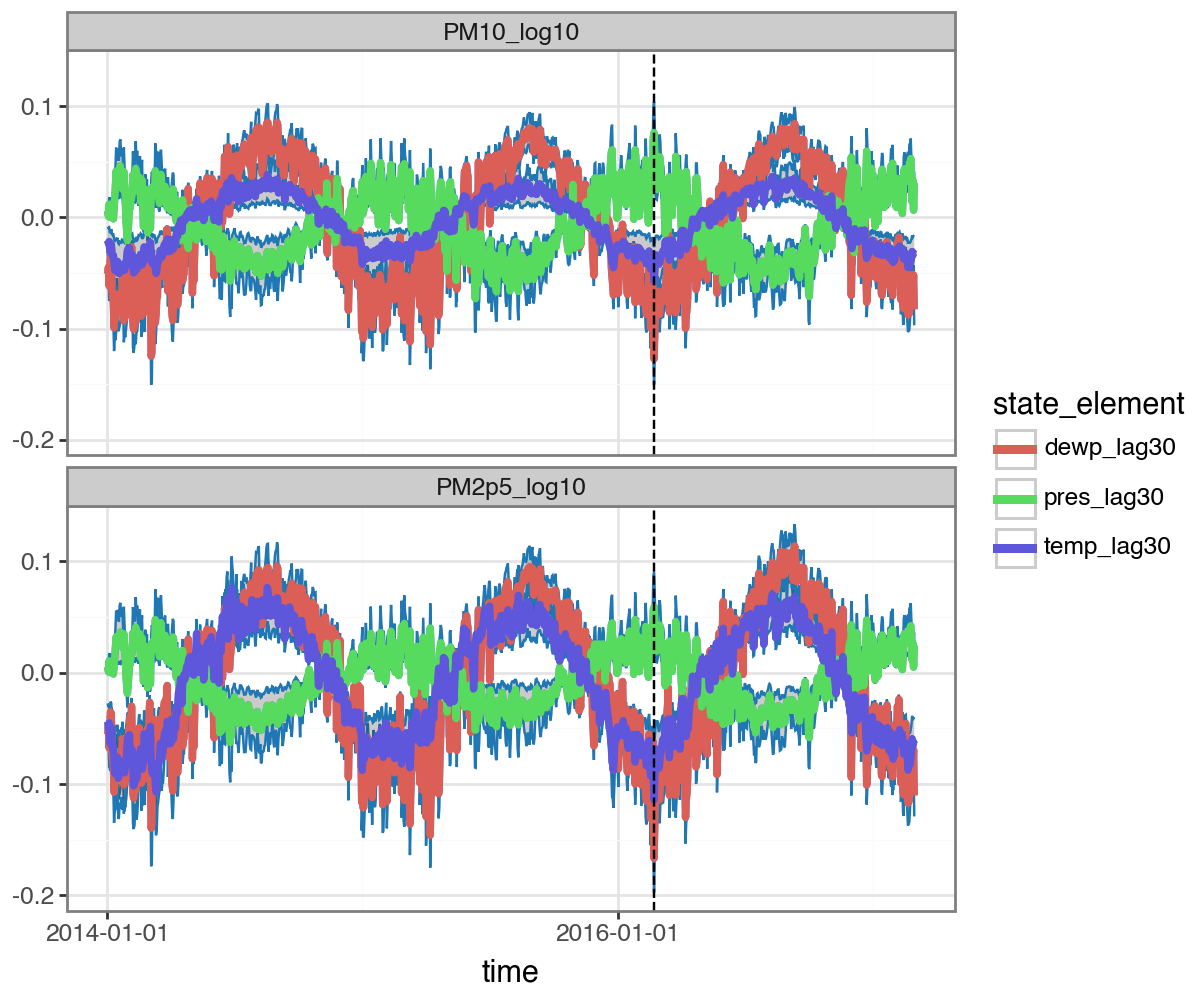

In [80]:
# inspect components:
with torch.no_grad():
    y, X = dataset_pm_lm.tensors
    one_mo_lm = kf_pm_lm(
        y,
        X=X,
        start_offsets=dataset_pm_lm.start_datetimes,
        n_step=30
    )
one_mo_lm.plot(
    one_mo_lm
    .to_dataframe(dataset_pm_lm, type='components')
    .query("process.str.contains('lm')")
    .query("time > '2014-01-01'"),
    split_dt=SPLIT_DT, 
    figure_size=(6,5)
) + facet_wrap('measure', ncol=1)

Now let's look at the change in error from our earlier multivariate model vs. one that includes predictors:

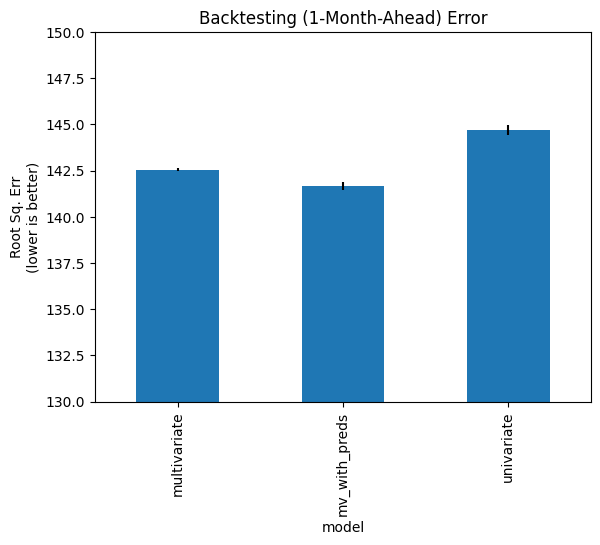

In [81]:
df_backtest1mo_err_agg2 = agg_within_group_err(
    pd.concat([
        # old ones:
        df_backtest_err1mo,
        # new one:
        mc_preds_to_dataframe(one_mo_lm,
                              dataset_pm_lm,
                              inverse_transform_fun=lambda x: 10 ** x,
                              group_colname='station',
                              time_colname='date')
        .loc[lambda df: df['date'] > SPLIT_DT,:]
        .merge(df_aq[['station', 'date', 'PM']])
        .pipe(get_station_error, pred_colname='predicted', actual_colname='PM')
        .assign(model='mv_with_preds')
    ])
)

df_backtest1mo_err_agg2['rmse'].plot(
    kind='bar', 
    yerr=df_backtest1mo_err_agg2['sem'] * sem_multi, 
    ylabel="Root Sq. Err\n(lower is better)", 
    title="Backtesting (1-Month-Ahead) Error",
    ylim=(130,150)
)
plt.show()